# CNN Training with Keras
This script trains a Convolutional Neural Network (CNN) on the CIFAR-10 dataset using Keras. It includes hyperparameter analysis and saves the best model's weights.

In [1]:
import tensorflow as tf
import keras
from keras import layers
from keras import callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_and_preprocess_data():
    (x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

    x_train, x_val, y_train, y_val = train_test_split(
        x_train_full, y_train_full, test_size=0.2, random_state=42
    )

    x_train = x_train.astype("float32") / 255.0
    x_val = x_val.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"x_val shape: {x_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [3]:
def build_cnn_model(num_conv_layers, filters_per_layer, filter_size, pooling_type, input_shape, num_classes=10):
    model = keras.Sequential()
    model.add(keras.Input(shape=input_shape))

    for i in range(num_conv_layers):
        model.add(layers.Conv2D(filters_per_layer[i], filter_size, activation='relu', padding='same'))
        if pooling_type == 'max':
            model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        elif pooling_type == 'avg':
            model.add(layers.AveragePooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_and_preprocess_data()
input_shape = x_train.shape[1:]
num_classes = 10
results = []
best_f1_score = -1
best_model_config = None
best_keras_model = None

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

hyperparameter_configs = [
    {'num_conv_layers': 1, 'filters_per_layer': [32], 'filter_size': (3,3), 'pooling_type': 'max'},
    {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (3,3), 'pooling_type': 'max'},
    {'num_conv_layers': 3, 'filters_per_layer': [32, 32, 32], 'filter_size': (3,3), 'pooling_type': 'max'},

    {'num_conv_layers': 2, 'filters_per_layer': [16, 32], 'filter_size': (3,3), 'pooling_type': 'max'},
    {'num_conv_layers': 2, 'filters_per_layer': [32, 64], 'filter_size': (3,3), 'pooling_type': 'max'},
    {'num_conv_layers': 2, 'filters_per_layer': [64, 128], 'filter_size': (3,3), 'pooling_type': 'max'},

    {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (3,3), 'pooling_type': 'max'},
    {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (5,5), 'pooling_type': 'max'},
    {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (7,7), 'pooling_type': 'max'},

    {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (3,3), 'pooling_type': 'max'},
    {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (3,3), 'pooling_type': 'avg'},
]

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


## Experiment Hyperparameters for Convvolutional Layer

Number of convolutional layers:
- 1
- 2
- 3

In [5]:
# Config 1.1: Single Convolutional Layer
config = hyperparameter_configs[0]
print(f"\n--- Training Model with Configuration 1.1: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history_1 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1_1 = f1_score(y_test, y_pred, average='macro')
print(f"Config 1.1 - Test Macro F1-Score: {macro_f1_1:.4f}")
results.append({'config': config, 'history': history_1.history, 'macro_f1': macro_f1_1})
if macro_f1_1 > best_f1_score:
    best_f1_score = macro_f1_1
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 1.1: {'num_conv_layers': 1, 'filters_per_layer': [32], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


2025-05-30 18:11:09.217347: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-05-30 18:11:09.217372: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-30 18:11:09.217377: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1748603469.217404  958655 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1748603469.217431  958655 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050,890 (4.01 MB)

 Trainable params: 1,050,890 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-05-30 18:11:09.846137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3841 - loss: 1.7143 - val_accuracy: 0.5076 - val_loss: 1.3796
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5653 - loss: 1.2323 - val_accuracy: 0.5906 - val_loss: 1.1804
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5993 - loss: 1.1498 - val_accuracy: 0.5825 - val_loss: 1.2227
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5990 - loss: 1.1614 - val_accuracy: 0.5525 - val_loss: 1.3993
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5917 - loss: 1.2471 - val_accuracy: 0.5663 - val_loss: 1.3833
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5770 - loss: 1.4000 - val_accuracy: 0.5213 - val_loss: 1.7423
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5468 - loss: 1.6937 - val_accuracy: 0.4986 - val_loss: 2.1221
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
313/313 ━━━

In [6]:
# Config 1.2: Two Convolutional Layers
config = hyperparameter_configs[1]
print(f"\n--- Training Model with Configuration 1.2: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history_2 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1_2 = f1_score(y_test, y_pred, average='macro')
print(f"Config 1.2 - Test Macro F1-Score: {macro_f1_2:.4f}")
results.append({'config': config, 'history': history_2.history, 'macro_f1': macro_f1_2})
if macro_f1_2 > best_f1_score:
    best_f1_score = macro_f1_2
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 1.2: {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,706 (1.04 MB)

 Trainable params: 273,706 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.3807 - loss: 1.7047 - val_accuracy: 0.5615 - val_loss: 1.2427
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5651 - loss: 1.2646 - val_accuracy: 0.5016 - val_loss: 1.6461
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4874 - loss: 2.2983 - val_accuracy: 0.3050 - val_loss: 11.6855
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3591 - loss: 16.4689 - val_accuracy: 0.3168 - val_loss: 36.4621
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3105 - loss: 57.7924 - val_accuracy: 0.3001 - val_loss: 93.9812
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.2932 - loss: 121.6354 - val_accuracy: 0.2399 - val_loss: 244.5183
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Config 1.2 - Test Macro F1-Score: 0.5489


In [7]:
# Config 1.3: Three Convolutional Layers
config = hyperparameter_configs[2]
print(f"\n--- Training Model with Configuration 1.3: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history_3 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1_3 = f1_score(y_test, y_pred, average='macro')
print(f"Config 1.3 - Test Macro F1-Score: {macro_f1_3:.4f}")
results.append({'config': config, 'history': history_3.history, 'macro_f1': macro_f1_3})
if macro_f1_3 > best_f1_score:
    best_f1_score = macro_f1_3
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 1.3: {'num_conv_layers': 3, 'filters_per_layer': [32, 32, 32], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,346 (337.29 KB)

 Trainable params: 86,346 (337.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.3543 - loss: 1.7722 - val_accuracy: 0.5102 - val_loss: 1.3468
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5237 - loss: 1.3538 - val_accuracy: 0.5357 - val_loss: 1.3982
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5031 - loss: 1.7465 - val_accuracy: 0.4202 - val_loss: 4.5808
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3900 - loss: 11.3196 - val_accuracy: 0.3788 - val_loss: 36.5221
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3508 - loss: 77.9929 - val_accuracy: 0.2752 - val_loss: 273.5685
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2979 - loss: 344.5058 - val_accuracy: 0.3143 - val_loss: 598.7390
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Config 1.3 - Test Macro F1-Score: 0.4867


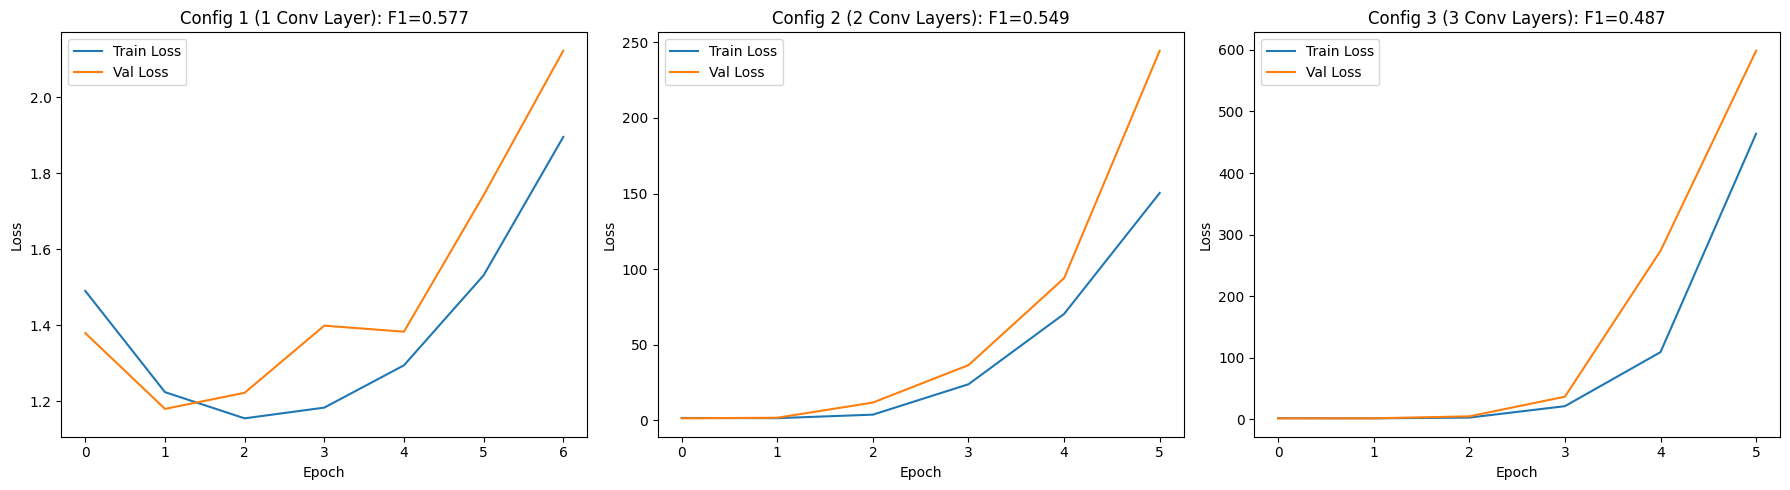


--- Convolutional Layer Experiment Summary ---
1 Conv Layer: F1-Score = 0.5774
2 Conv Layers: F1-Score = 0.5489
3 Conv Layers: F1-Score = 0.4867


In [8]:
# Plot results for Convolutional Layer experiments
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Config 1.1: Single Convolutional Layer
axes[0].plot(history_1.history['loss'], label='Train Loss')
axes[0].plot(history_1.history['val_loss'], label='Val Loss')
axes[0].set_title(f"Config 1 (1 Conv Layer): F1={macro_f1_1:.3f}")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Config 1.2: Two Convolutional Layers
axes[1].plot(history_2.history['loss'], label='Train Loss')
axes[1].plot(history_2.history['val_loss'], label='Val Loss')
axes[1].set_title(f"Config 2 (2 Conv Layers): F1={macro_f1_2:.3f}")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Config 1.3: Three Convolutional Layers
axes[2].plot(history_3.history['loss'], label='Train Loss')
axes[2].plot(history_3.history['val_loss'], label='Val Loss')
axes[2].set_title(f"Config 3 (3 Conv Layers): F1={macro_f1_3:.3f}")
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()
plt.show()

# Summary of the convolution layer experiment
print("\n--- Convolutional Layer Experiment Summary ---")
print(f"1 Conv Layer: F1-Score = {macro_f1_1:.4f}")
print(f"2 Conv Layers: F1-Score = {macro_f1_2:.4f}")
print(f"3 Conv Layers: F1-Score = {macro_f1_3:.4f}")

## Experiment Hyperparameters for Filter per Convolutional Layer

Number of filter per convolutional layer:
- 16, 32
- 32, 64
- 64, 128

In [9]:
# Config 2.1: 16, 32 Filters
config = hyperparameter_configs[3]
print(f"\n--- Training Model with Configuration 2.1: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history_4 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1_4 = f1_score(y_test, y_pred, average='macro')
print(f"Config 2.1 - Test Macro F1-Score: {macro_f1_4:.4f}")
results.append({'config': config, 'history': history_4.history, 'macro_f1': macro_f1_4})
if macro_f1_4 > best_f1_score:
    best_f1_score = macro_f1_4
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 2.1: {'num_conv_layers': 2, 'filters_per_layer': [16, 32], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,650 (1.02 MB)

 Trainable params: 268,650 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.3645 - loss: 1.7438 - val_accuracy: 0.5323 - val_loss: 1.3040
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5606 - loss: 1.2327 - val_accuracy: 0.5882 - val_loss: 1.1686
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6101 - loss: 1.1213 - val_accuracy: 0.5821 - val_loss: 1.2497
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6012 - loss: 1.1880 - val_accuracy: 0.5542 - val_loss: 1.5291
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5661 - loss: 1.5634 - val_accuracy: 0.5244 - val_loss: 2.3460
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5270 - loss: 2.5413 - val_accuracy: 0.5323 - val_loss: 3.4040
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4844 - loss: 4.7936 - val_accuracy: 0.4663 - val_loss: 7.3190
Epoch 7: early stopping
Restoring model weights from the end of the best epo

In [10]:
# Config 2.2: 32, 64 Filters
config = hyperparameter_configs[4]
print(f"\n--- Training Model with Configuration 2.2: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history_5 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1_5 = f1_score(y_test, y_pred, average='macro')
print(f"Config 2.2 - Test Macro F1-Score: {macro_f1_5:.4f}")
results.append({'config': config, 'history': history_5.history, 'macro_f1': macro_f1_5})
if macro_f1_5 > best_f1_score:
    best_f1_score = macro_f1_5
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 2.2: {'num_conv_layers': 2, 'filters_per_layer': [32, 64], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3926 - loss: 1.6870 - val_accuracy: 0.5519 - val_loss: 1.2667
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5843 - loss: 1.1861 - val_accuracy: 0.5760 - val_loss: 1.2872
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5883 - loss: 1.2960 - val_accuracy: 0.5599 - val_loss: 1.7299
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5088 - loss: 2.8393 - val_accuracy: 0.4669 - val_loss: 5.6663
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4373 - loss: 11.2448 - val_accuracy: 0.4152 - val_loss: 28.7562
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3876 - loss: 38.4252 - val_accuracy: 0.4093 - val_loss: 65.7787
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Config 2.2 - Test Macro F1-Score: 0.5312


In [11]:
# Config 2.3: 64, 128 Filters
config = hyperparameter_configs[5]
print(f"\n--- Training Model with Configuration 2.3: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history_6 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1_6 = f1_score(y_test, y_pred, average='macro')
print(f"Config 2.3 - Test Macro F1-Score: {macro_f1_6:.4f}")
results.append({'config': config, 'history': history_6.history, 'macro_f1': macro_f1_6})
if macro_f1_6 > best_f1_score:
    best_f1_score = macro_f1_6
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 2.3: {'num_conv_layers': 2, 'filters_per_layer': [64, 128], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,642 (4.29 MB)

 Trainable params: 1,125,642 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.3950 - loss: 1.6634 - val_accuracy: 0.5594 - val_loss: 1.2431
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6059 - loss: 1.1353 - val_accuracy: 0.6179 - val_loss: 1.1176
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6289 - loss: 1.0934 - val_accuracy: 0.6125 - val_loss: 1.2006
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6190 - loss: 1.2492 - val_accuracy: 0.5788 - val_loss: 1.7590
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5905 - loss: 1.8667 - val_accuracy: 0.5649 - val_loss: 2.7272
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5712 - loss: 2.9749 - val_accuracy: 0.4386 - val_loss: 7.7876
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5502 - loss: 5.6367 - val_accuracy: 0.5391 - val_loss: 8.1132
Epoch 7: early stopping
Restoring model weights from the end of the best epo

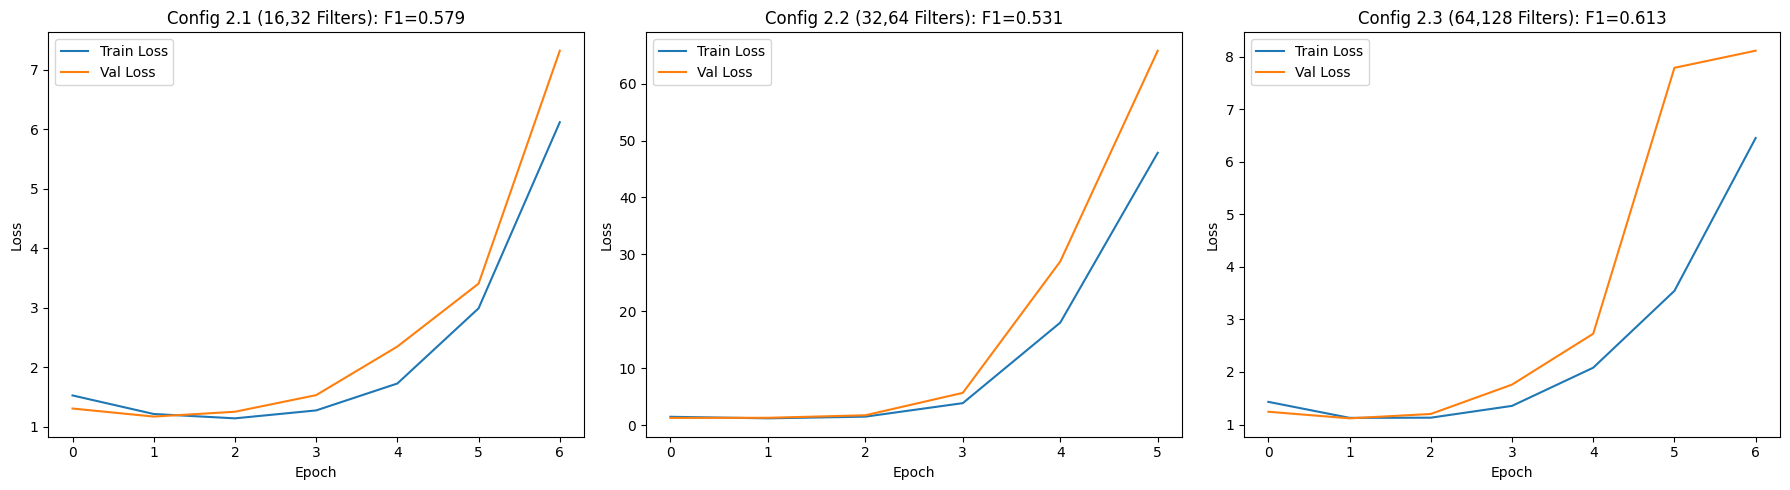


--- Filter per Convolutional Layer Experiment Summary ---
16,32 Filters: F1-Score = 0.5785
32,64 Filters: F1-Score = 0.5312
64,128 Filters: F1-Score = 0.6130


In [12]:
# Plot results for Filter per Convolutional Layer experiments
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Config 2.1: 16, 32 Filters
axes[0].plot(history_4.history['loss'], label='Train Loss')
axes[0].plot(history_4.history['val_loss'], label='Val Loss')
axes[0].set_title(f"Config 2.1 (16,32 Filters): F1={macro_f1_4:.3f}")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Config 2.2: 32, 64 Filters
axes[1].plot(history_5.history['loss'], label='Train Loss')
axes[1].plot(history_5.history['val_loss'], label='Val Loss')
axes[1].set_title(f"Config 2.2 (32,64 Filters): F1={macro_f1_5:.3f}")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Config 2.3: 64, 128 Filters
axes[2].plot(history_6.history['loss'], label='Train Loss')
axes[2].plot(history_6.history['val_loss'], label='Val Loss')
axes[2].set_title(f"Config 2.3 (64,128 Filters): F1={macro_f1_6:.3f}")
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()
plt.show()

# Summary of the filter experiment
print("\n--- Filter per Convolutional Layer Experiment Summary ---")
print(f"16,32 Filters: F1-Score = {macro_f1_4:.4f}")
print(f"32,64 Filters: F1-Score = {macro_f1_5:.4f}")
print(f"64,128 Filters: F1-Score = {macro_f1_6:.4f}")

## Experiment Hyperparameters for Filter Size per Convolutional Layer

Number of filter size per convolutional layer:
- 3x3
- 5x5
- 7x7

In [13]:
# Config 3.1: 3x3 Filter Size
config = hyperparameter_configs[6]
print(f"\n--- Training Model with Configuration 3.1: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history_7 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1_7 = f1_score(y_test, y_pred, average='macro')
print(f"Config 3.1 - Test Macro F1-Score: {macro_f1_7:.4f}")
results.append({'config': config, 'history': history_7.history, 'macro_f1': macro_f1_7})
if macro_f1_7 > best_f1_score:
    best_f1_score = macro_f1_7
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 3.1: {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,706 (1.04 MB)

 Trainable params: 273,706 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.3871 - loss: 1.6798 - val_accuracy: 0.5716 - val_loss: 1.2116
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5944 - loss: 1.1664 - val_accuracy: 0.5958 - val_loss: 1.1577
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6208 - loss: 1.1084 - val_accuracy: 0.6087 - val_loss: 1.1920
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6043 - loss: 1.3158 - val_accuracy: 0.4997 - val_loss: 2.1942
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5525 - loss: 2.1022 - val_accuracy: 0.4955 - val_loss: 4.3121
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4825 - loss: 5.8062 - val_accuracy: 0.3814 - val_loss: 18.0399
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4417 - loss: 15.3227 - val_accuracy: 0.3543 - val_loss: 43.0407
Epoch 7: early stopping
Restoring model weights from the end of the best 

In [14]:
# Config 3.2: 5x5 Filter Size
config = hyperparameter_configs[7]
print(f"\n--- Training Model with Configuration 3.2: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history_8 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1_8 = f1_score(y_test, y_pred, average='macro')
print(f"Config 3.2 - Test Macro F1-Score: {macro_f1_8:.4f}")
results.append({'config': config, 'history': history_8.history, 'macro_f1': macro_f1_8})
if macro_f1_8 > best_f1_score:
    best_f1_score = macro_f1_8
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 3.2: {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (5, 5), 'pooling_type': 'max'} ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,626 (1.11 MB)

 Trainable params: 291,626 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3488 - loss: 1.7900 - val_accuracy: 0.5044 - val_loss: 1.4064
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4937 - loss: 1.5000 - val_accuracy: 0.4426 - val_loss: 2.3629
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4351 - loss: 3.1117 - val_accuracy: 0.3949 - val_loss: 8.8025
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.3889 - loss: 14.1329 - val_accuracy: 0.3615 - val_loss: 46.3985
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3617 - loss: 53.9818 - val_accuracy: 0.3172 - val_loss: 108.2970
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3486 - loss: 120.6745 - val_accuracy: 0.3142 - val_loss: 203.7874
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Config 3.2 - Test Macro F1-Score: 0.4979


In [15]:
# Config 3.3: 7x7 Filter Size
config = hyperparameter_configs[8]
print(f"\n--- Training Model with Configuration 3.3: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history_9 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1_9 = f1_score(y_test, y_pred, average='macro')
print(f"Config 3.3 - Test Macro F1-Score: {macro_f1_9:.4f}")
results.append({'config': config, 'history': history_9.history, 'macro_f1': macro_f1_9})
if macro_f1_9 > best_f1_score:
    best_f1_score = macro_f1_9
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 3.3: {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (7, 7), 'pooling_type': 'max'} ---


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,506 (1.22 MB)

 Trainable params: 318,506 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3184 - loss: 1.8583 - val_accuracy: 0.4836 - val_loss: 1.4611
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.4746 - loss: 1.5415 - val_accuracy: 0.5058 - val_loss: 1.5179
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.4503 - loss: 2.2891 - val_accuracy: 0.4245 - val_loss: 4.1207
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.3946 - loss: 8.0215 - val_accuracy: 0.3861 - val_loss: 21.2064
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.3676 - loss: 31.0638 - val_accuracy: 0.3174 - val_loss: 78.9925
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.3670 - loss: 69.5257 - val_accuracy: 0.2874 - val_loss: 177.2360
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Config 3.3 - Test Macro F1-Score: 0.4854


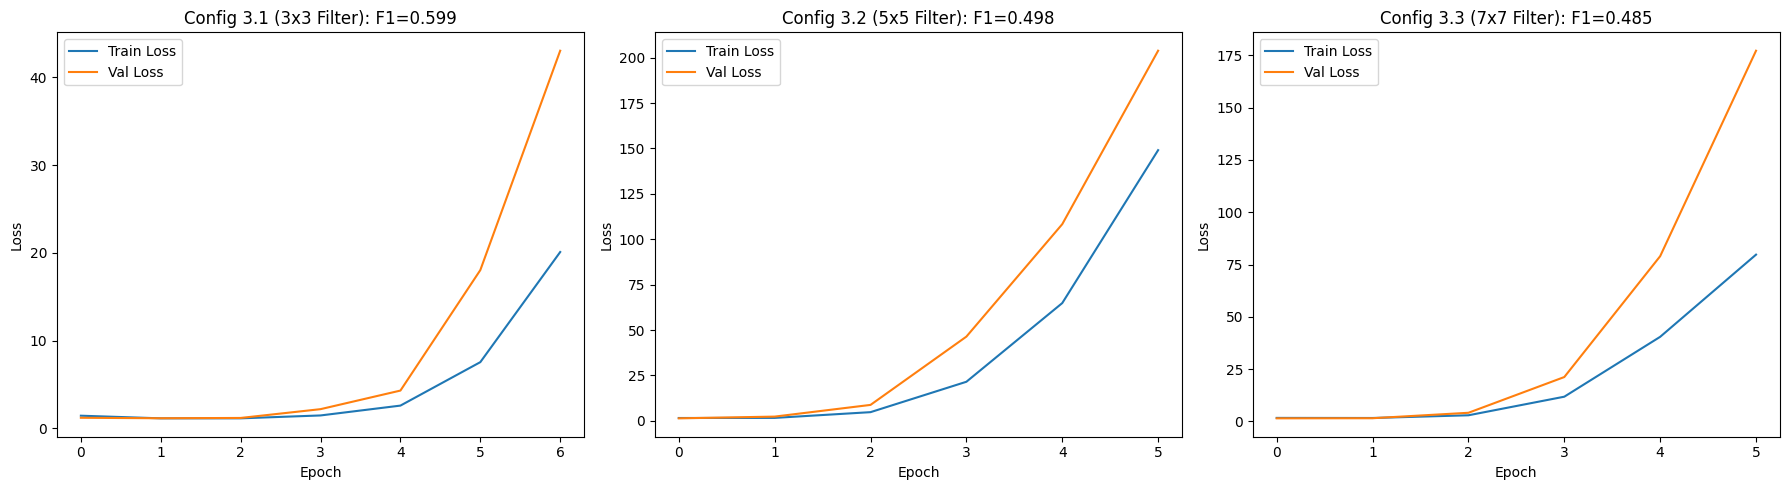


--- Filter Size per Convolutional Layer Experiment Summary ---
3x3 Filter: F1-Score = 0.5992
5x5 Filter: F1-Score = 0.4979
7x7 Filter: F1-Score = 0.4854


In [16]:
# Plot results for Filter Size per Convolutional Layer experiments
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Config 3.1: 3x3 Filter Size
axes[0].plot(history_7.history['loss'], label='Train Loss')
axes[0].plot(history_7.history['val_loss'], label='Val Loss')
axes[0].set_title(f"Config 3.1 (3x3 Filter): F1={macro_f1_7:.3f}")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Config 3.2: 5x5 Filter Size
axes[1].plot(history_8.history['loss'], label='Train Loss')
axes[1].plot(history_8.history['val_loss'], label='Val Loss')
axes[1].set_title(f"Config 3.2 (5x5 Filter): F1={macro_f1_8:.3f}")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Config 3.3: 7x7 Filter Size
axes[2].plot(history_9.history['loss'], label='Train Loss')
axes[2].plot(history_9.history['val_loss'], label='Val Loss')
axes[2].set_title(f"Config 3.3 (7x7 Filter): F1={macro_f1_9:.3f}")
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()
plt.show()

# Summary of the filter size experiment
print("\n--- Filter Size per Convolutional Layer Experiment Summary ---")
print(f"3x3 Filter: F1-Score = {macro_f1_7:.4f}")
print(f"5x5 Filter: F1-Score = {macro_f1_8:.4f}")
print(f"7x7 Filter: F1-Score = {macro_f1_9:.4f}")

## Experiment Hyperparameters for Pooling Layer Type

Pooling layer type:
- MaxPooling
- AveragePooling

In [17]:
# Config 4.1: Max Pooling
config = hyperparameter_configs[9]
print(f"\n--- Training Model with Configuration 4.1: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history_10 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1_10 = f1_score(y_test, y_pred, average='macro')
print(f"Config 4.1 - Test Macro F1-Score: {macro_f1_10:.4f}")
results.append({'config': config, 'history': history_10.history, 'macro_f1': macro_f1_10})
if macro_f1_10 > best_f1_score:
    best_f1_score = macro_f1_10
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 4.1: {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,706 (1.04 MB)

 Trainable params: 273,706 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3781 - loss: 1.7126 - val_accuracy: 0.5538 - val_loss: 1.2727
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5668 - loss: 1.2346 - val_accuracy: 0.5885 - val_loss: 1.1882
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5786 - loss: 1.2459 - val_accuracy: 0.5860 - val_loss: 1.3287
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5520 - loss: 1.6251 - val_accuracy: 0.4946 - val_loss: 2.5831
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4906 - loss: 3.7923 - val_accuracy: 0.4933 - val_loss: 6.2395
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4533 - loss: 10.5715 - val_accuracy: 0.3873 - val_loss: 27.9886
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3973 - loss: 34.9358 - val_accuracy: 0.3776 - val_loss: 76.8881
Epoch 7: early stopping
Restoring model weights from the end of the best

In [18]:
# Config 4.2: Average Pooling
config = hyperparameter_configs[10]
print(f"\n--- Training Model with Configuration 4.2: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history_11 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1_11 = f1_score(y_test, y_pred, average='macro')
print(f"Config 4.2 - Test Macro F1-Score: {macro_f1_11:.4f}")
results.append({'config': config, 'history': history_11.history, 'macro_f1': macro_f1_11})
if macro_f1_11 > best_f1_score:
    best_f1_score = macro_f1_11
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 4.2: {'num_conv_layers': 2, 'filters_per_layer': [32, 32], 'filter_size': (3, 3), 'pooling_type': 'avg'} ---


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 16, 16, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 8, 8, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,706 (1.04 MB)

 Trainable params: 273,706 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.3516 - loss: 1.7841 - val_accuracy: 0.5002 - val_loss: 1.3829
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5128 - loss: 1.3649 - val_accuracy: 0.5078 - val_loss: 1.4428
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4719 - loss: 1.9431 - val_accuracy: 0.3837 - val_loss: 4.2675
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3485 - loss: 10.3502 - val_accuracy: 0.2682 - val_loss: 32.4033
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.2788 - loss: 49.9062 - val_accuracy: 0.2944 - val_loss: 112.8769
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2469 - loss: 149.0666 - val_accuracy: 0.2448 - val_loss: 263.5505
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Config 4.2 - Test Macro F1-Score: 0.4899


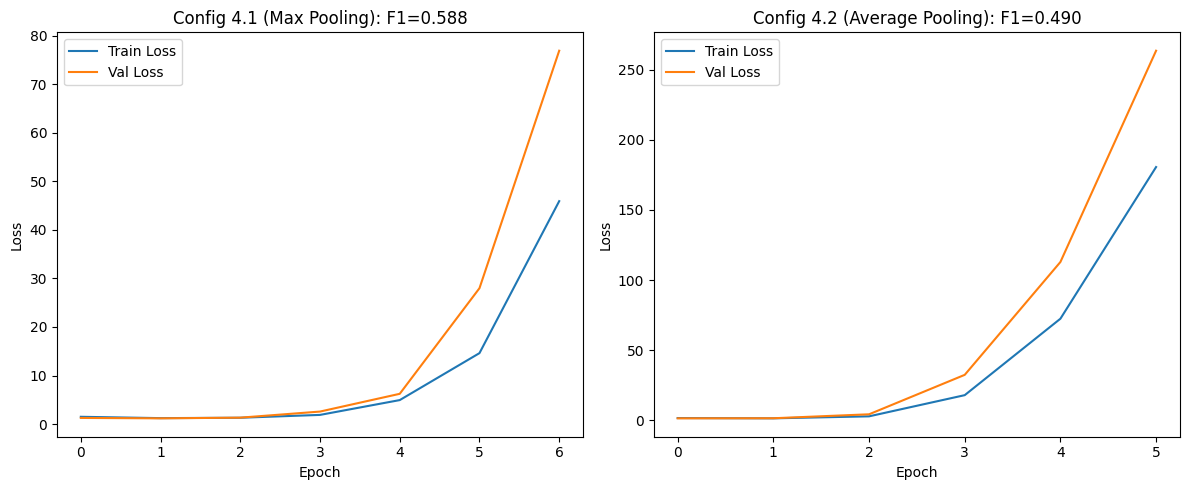


--- Pooling Layer Type Experiment Summary ---
Max Pooling: F1-Score = 0.5879
Average Pooling: F1-Score = 0.4899


In [19]:
# Plot results for Pooling Layer Type experiments
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Config 4.1: Max Pooling
axes[0].plot(history_10.history['loss'], label='Train Loss')
axes[0].plot(history_10.history['val_loss'], label='Val Loss')
axes[0].set_title(f"Config 4.1 (Max Pooling): F1={macro_f1_10:.3f}")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Config 4.2: Average Pooling
axes[1].plot(history_11.history['loss'], label='Train Loss')
axes[1].plot(history_11.history['val_loss'], label='Val Loss')
axes[1].set_title(f"Config 4.2 (Average Pooling): F1={macro_f1_11:.3f}")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

# Summary of the pooling type experiment
print("\n--- Pooling Layer Type Experiment Summary ---")
print(f"Max Pooling: F1-Score = {macro_f1_10:.4f}")
print(f"Average Pooling: F1-Score = {macro_f1_11:.4f}")


COMPREHENSIVE EXPERIMENT RESULTS SUMMARY

1. CONVOLUTIONAL LAYER EXPERIMENTS:
   • 1 Conv Layer:  F1-Score = 0.5774
   • 2 Conv Layers: F1-Score = 0.5489
   • 3 Conv Layers: F1-Score = 0.4867

2. FILTER PER LAYER EXPERIMENTS:
   • 16,32 Filters:  F1-Score = 0.5785
   • 32,64 Filters:  F1-Score = 0.5312
   • 64,128 Filters: F1-Score = 0.6130

3. FILTER SIZE EXPERIMENTS:
   • 3x3 Filter: F1-Score = 0.5992
   • 5x5 Filter: F1-Score = 0.4979
   • 7x7 Filter: F1-Score = 0.4854

4. POOLING TYPE EXPERIMENTS:
   • Max Pooling:     F1-Score = 0.5879
   • Average Pooling: F1-Score = 0.4899

BEST MODEL CONFIGURATION: F1-Score = 0.6130
{'num_conv_layers': 2, 'filters_per_layer': [64, 128], 'filter_size': (3, 3), 'pooling_type': 'max'}

Re-training the best model for more epochs (up to 100)...


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,642 (4.29 MB)

 Trainable params: 1,125,642 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.3943 - loss: 1.6703 - val_accuracy: 0.5953 - val_loss: 1.1739
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6007 - loss: 1.1477 - val_accuracy: 0.6301 - val_loss: 1.0968
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6227 - loss: 1.1378 - val_accuracy: 0.5758 - val_loss: 1.4891
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5774 - loss: 1.6483 - val_accuracy: 0.5437 - val_loss: 2.7366
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5176 - loss: 4.3349 - val_accuracy: 0.4818 - val_loss: 10.7875
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4807 - loss: 15.0390 - val_accuracy: 0.4447 - val_loss: 32.8280
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.4446 - loss: 41.0352 - val_accuracy: 0.3964 - val_loss: 79.2265
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accur

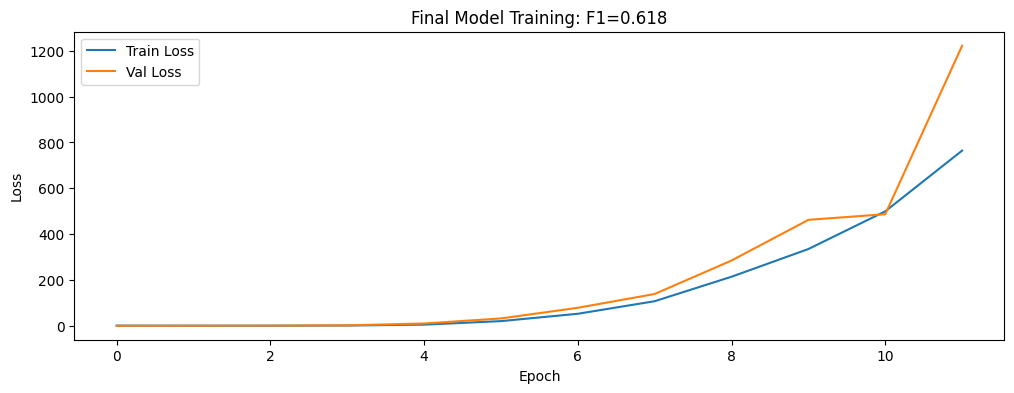

In [21]:
print("\n" + "="*80)
print("COMPREHENSIVE EXPERIMENT RESULTS SUMMARY")
print("="*80)

print("\n1. CONVOLUTIONAL LAYER EXPERIMENTS:")
print(f"   • 1 Conv Layer:  F1-Score = {macro_f1_1:.4f}")
print(f"   • 2 Conv Layers: F1-Score = {macro_f1_2:.4f}")
print(f"   • 3 Conv Layers: F1-Score = {macro_f1_3:.4f}")

print("\n2. FILTER PER LAYER EXPERIMENTS:")
print(f"   • 16,32 Filters:  F1-Score = {macro_f1_4:.4f}")
print(f"   • 32,64 Filters:  F1-Score = {macro_f1_5:.4f}")
print(f"   • 64,128 Filters: F1-Score = {macro_f1_6:.4f}")

print("\n3. FILTER SIZE EXPERIMENTS:")
print(f"   • 3x3 Filter: F1-Score = {macro_f1_7:.4f}")
print(f"   • 5x5 Filter: F1-Score = {macro_f1_8:.4f}")
print(f"   • 7x7 Filter: F1-Score = {macro_f1_9:.4f}")

print("\n4. POOLING TYPE EXPERIMENTS:")
print(f"   • Max Pooling:     F1-Score = {macro_f1_10:.4f}")
print(f"   • Average Pooling: F1-Score = {macro_f1_11:.4f}")

print("\n" + "="*80)
print(f"BEST MODEL CONFIGURATION: F1-Score = {best_f1_score:.4f}")
print(best_model_config)
print("="*80)

if best_keras_model and best_model_config:
    print("\nRe-training the best model for more epochs (up to 100)...")
    
    final_early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
    
    final_model = build_cnn_model(**best_model_config, input_shape=input_shape, num_classes=num_classes)
    final_model.summary()
    final_history = final_model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[final_early_stopping], verbose=1)
    final_y_pred_proba = final_model.predict(x_test)
    final_y_pred = np.argmax(final_y_pred_proba, axis=1)
    final_macro_f1 = f1_score(y_test, final_y_pred, average='macro')
    print(f"\nFinal Model Test Macro F1-Score after extended training: {final_macro_f1:.4f}")
    final_model.save_weights('cnn_keras_final.weights.h5')
    print("Saved final Keras model weights to cnn_keras_final.weights.h5")
    
    import json
    config_dict = {
        'num_conv_layers': best_model_config['num_conv_layers'],
        'filters_per_layer': best_model_config['filters_per_layer'],
        'filter_size': best_model_config['filter_size'],
        'pooling_type': best_model_config['pooling_type'],
        'final_f1_score': final_macro_f1
    }
    with open('best_model_config.json', 'w') as f:
        json.dump(config_dict, f, indent=2)
    print("Saved best model configuration to best_model_config.json")
    
    plt.figure(figsize=(12, 4))
    plt.plot(final_history.history['loss'], label='Train Loss')
    plt.plot(final_history.history['val_loss'], label='Val Loss')
    plt.title(f"Final Model Training: F1={final_macro_f1:.3f}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("No model was trained successfully to save weights.")